<h1 style="text-align:center;">Valorant Pro Match Analysis</h1>


In [21]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def val_df_gen(db_name):
    """
    Dataset:
    https://www.kaggle.com/visualize25/valorant-pro-matches-full-data

    """

    val_sql = sql.connect('/content/drive/MyDrive/Valorant/valorant.sqlite')

    scoreboard_df = pd.read_sql("""
    SELECT
        *
    FROM
        Game_Scoreboard
    """, val_sql)
    rounds_df = pd.read_sql("""
        SELECT
            *
        FROM
            Game_Rounds
    """, val_sql)
    games_df = pd.read_sql("""
        SELECT
            *
        FROM
            Games
    """, val_sql)
    matches_df = pd.read_sql("""
        SELECT
            *
        FROM
            Matches
    """, val_sql)

    val_sql.close()

    merge_df = matches_df.merge(games_df)
    merge_df = merge_df.merge(rounds_df)
    merge_df = merge_df.merge(scoreboard_df)
    merge_df['MatchID'] = merge_df['MatchID'].astype(int)

    scoreboard_df = scoreboard_df.dropna()
    rounds_df = rounds_df.dropna()
    games_df = games_df.dropna()
    matches_df = matches_df.dropna()
    merge_df = merge_df.dropna()

    scoreboard_df.to_csv('sb_df.csv')
    rounds_df.to_csv('r_df.csv')
    games_df.to_csv('g_df.csv')
    matches_df.to_csv('ma_df.csv')
    merge_df.to_csv('me_df.csv')

    return scoreboard_df, rounds_df, games_df, matches_df, merge_df

In [4]:
def df_creator():
    """
    Attempts to read .csv files for the dataframes. If there are none,
    attempts to generate them by reading them in from the sql db file.
    """
    try:
        print('Reading .csv files')
        sb_df = pd.read_csv('sb_df.csv')
        r_df = pd.read_csv('r_df.csv')
        g_df = pd.read_csv('g_df.csv')
        ma_df = pd.read_csv('ma_df.csv')
        me_df = pd.read_csv('me_df.csv')
    except IOError:
        print('.csv files not found. Creating .csv files')
        sb_df, r_df, g_df, ma_df, me_df = val_df_gen('valorant.sqlite')

    return sb_df, r_df, g_df, ma_df,

In [5]:
%%capture
df_creator()

In [6]:
scoreboard_df = pd.read_csv('sb_df.csv')
rounds_df = pd.read_csv('r_df.csv')
games_df = pd.read_csv('g_df.csv')
matches_df = pd.read_csv('ma_df.csv')
merge_df = pd.read_csv('me_df.csv')

In [7]:
scoreboard_df_prep = scoreboard_df.drop(['Unnamed: 0', 'PlayerID', 'TeamAbbreviation', 'PlusMinus', 'FirstKills', 'FirstDeaths',
       'FKFD_PlusMinus', 'Num_2Ks', 'Num_3Ks', 'Num_4Ks', 'Num_5Ks', 'OnevOne',
       'OnevTwo', 'OnevThree', 'OnevFour', 'OnevFive', 'Econ', 'Plants',
       'Defuses'], axis=1)

print(scoreboard_df_prep.columns)

scoreboard_df_prep = pd.get_dummies(scoreboard_df_prep, columns=['PlayerName']) #One hot encoding
scoreboard_df_prep.head(10)

Index(['GameID', 'PlayerName', 'Agent', 'ACS', 'Kills', 'Deaths', 'Assists',
       'KAST_Percent', 'ADR', 'HS_Percent'],
      dtype='object')


,GameID,Agent,ACS,Kills,Deaths,Assists,KAST_Percent,ADR,HS_Percent,PlayerName_1TaPGoD,...,PlayerName_zeeq,PlayerName_zekken,PlayerName_zeldris,PlayerName_zhan,PlayerName_zill,PlayerName_zizox,PlayerName_zombs,PlayerName_zyad,PlayerName_zyf,PlayerName_Λero
0,60894,jett,313.0,24.0,10.0,3.0,0.65,195.0,0.31,0,...,0,0,0,0,0,0,0,0,0,0
1,60894,chamber,227.0,16.0,10.0,7.0,0.90,161.0,0.16,0,...,0,0,0,0,0,0,0,0,0,0
2,60894,sova,226.0,17.0,9.0,8.0,0.85,148.0,0.27,0,...,0,0,0,0,0,0,0,0,0,0
3,60894,viper,218.0,17.0,12.0,2.0,0.70,141.0,0.19,0,...,0,0,0,0,0,0,0,0,0,0
4,60894,skye,80.0,5.0,13.0,3.0,0.70,55.0,0.22,0,...,0,0,0,0,0,0,0,0,0,0
5,60894,astra,229.0,15.0,16.0,5.0,0.55,155.0,0.31,0,...,0,0,0,0,0,0,0,0,0,0
6,60894,sova,203.0,12.0,14.0,6.0,0.65,151.0,0.22,0,...,0,0,0,0,0,0,0,0,0,0
7,60894,chamber,173.0,12.0,16.0,2.0,0.70,103.0,0.18,0,...,0,0,0,0,0,0,0,0,0,0
8,60894,skye,125.0,9.0,15.0,1.0,0.50,94.0,0.36,0,...,0,0,0,0,0,0,0,0,0,0
9,60894,viper,89.0,6.0,18.0,3.0,0.45,57.0,0.22,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
name = "yay"
column = "ADR"

# Create a boolean mask that selects rows where 'PlayerName' == name
mask = merge_df['PlayerName'] == name

# Use the boolean mask to select the rows where 'PlayerName' == name and the desired column
data = merge_df.loc[mask, [column]]

# Check if any data was found
if not data.empty:
    print("The {} for player {} is:".format(column, name))
    display(data)
else:
    print("No data found for player {} in column {}.".format(name, column))

The ADR for player yay is:


,ADR
2421,95.0
2427,178.0
2437,187.0
2512,146.0
2522,208.0
2637,165.0
2647,140.0


# Prediction of Winning Team

<h2>Pre-processing Data</h2>

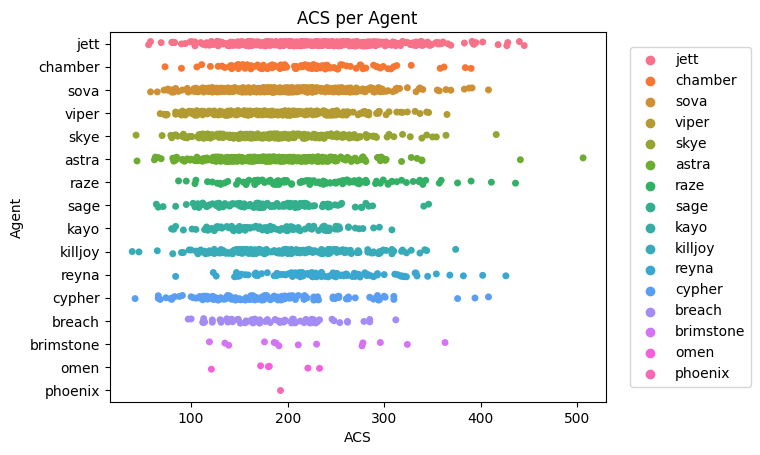

In [22]:
# ACS per agent numerical value (RQ1)
merge_df.groupby('Agent')['ACS'].mean()

# graph for ACS per agent (RQ1)
sns.stripplot(data=merge_df, x="ACS", y="Agent", hue="Agent")

plt.title("ACS per Agent")
plt.xlabel("ACS")
plt.ylabel("Agent")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

Text(50.77770833333334, 0.5, 'Map')

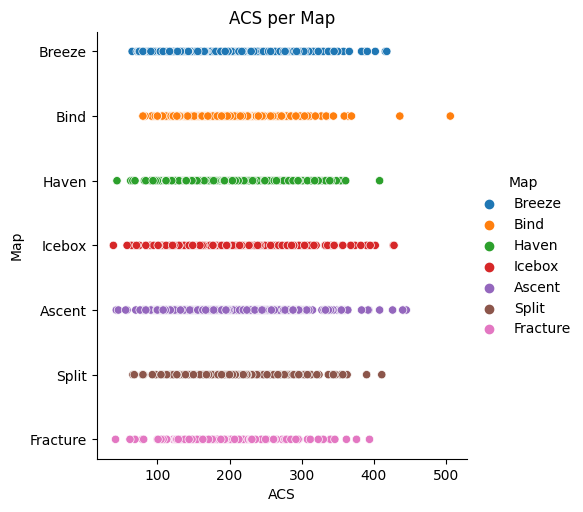

In [23]:
# ACS per map numerical value (RQ1)
merge_df.groupby('Map')['ACS'].mean()

# graph for ACS per map (RQ1)
sns.relplot(data=merge_df, x="ACS", y="Map", hue="Map")

plt.title("ACS per Map")
plt.xlabel("ACS")
plt.ylabel("Map")

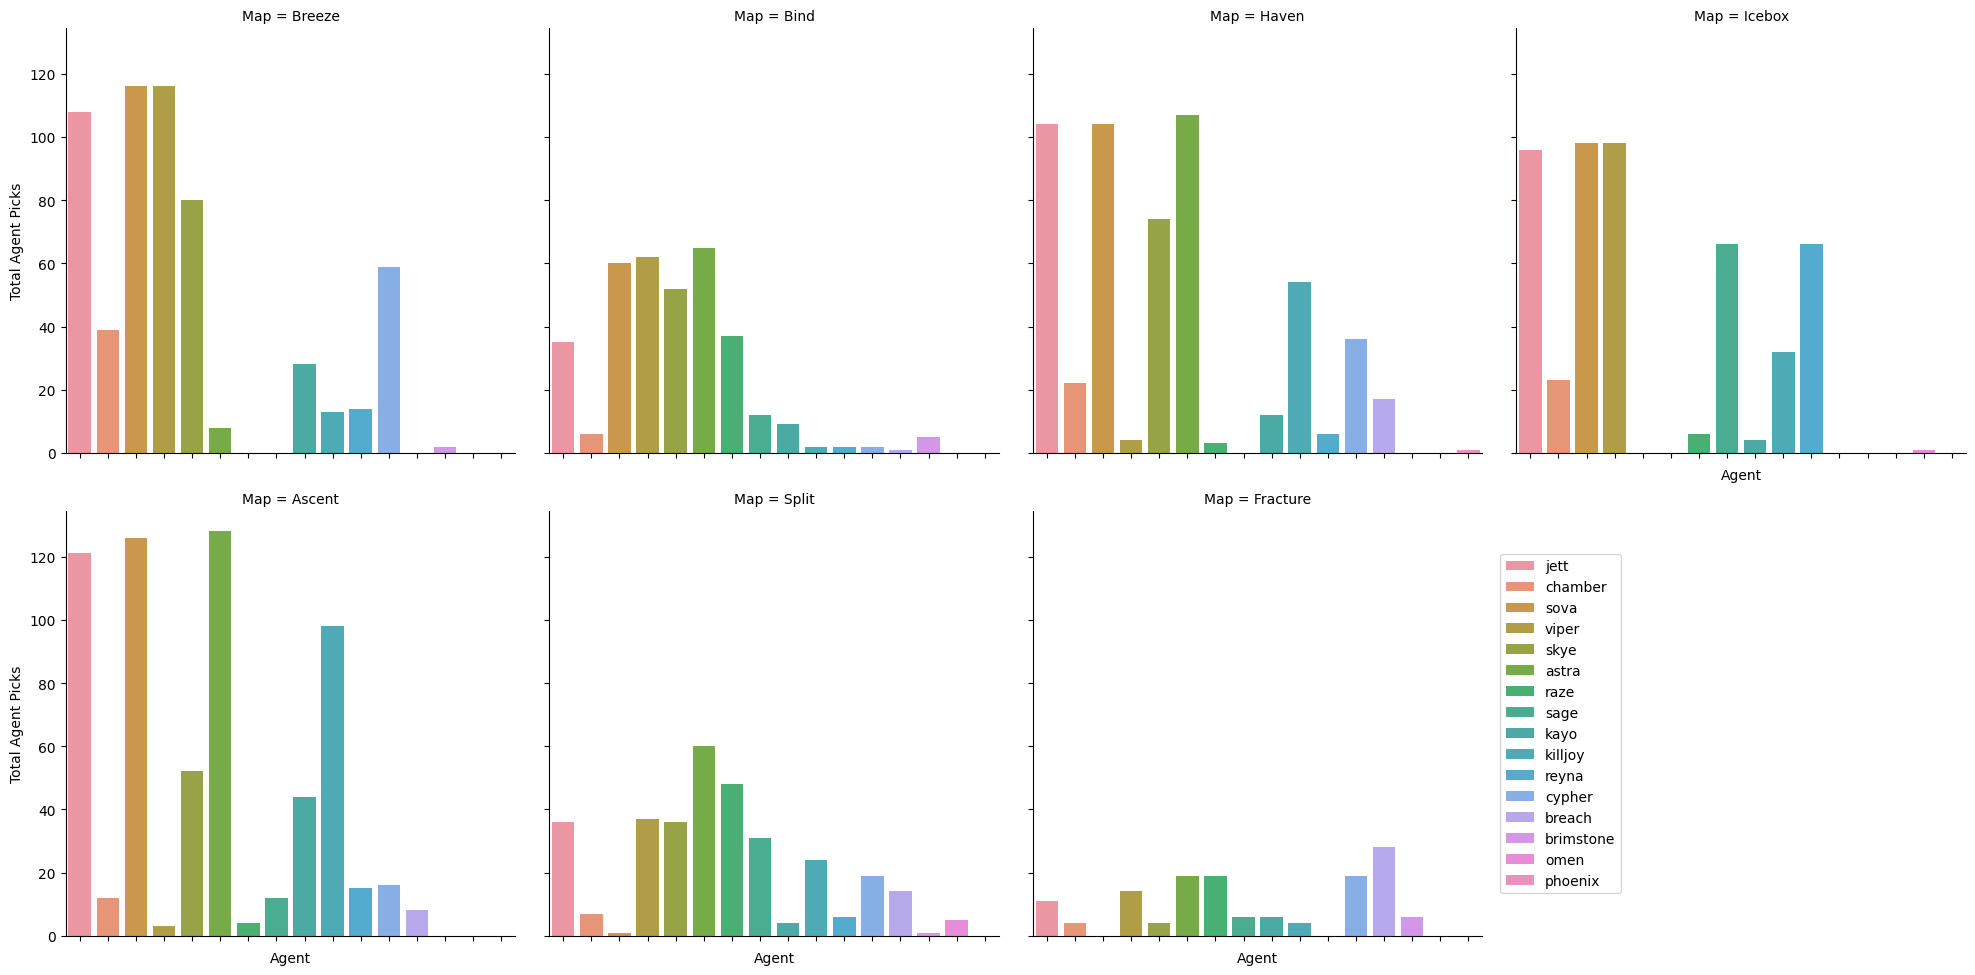

In [24]:
g = sns.catplot(x="Agent", col="Map", col_wrap=4,
                data=merge_df, kind="count", hue='Agent', dodge=False)
g.set_axis_labels("Agent", "Total Agent Picks")
g.set_xticklabels(rotation=65, horizontalalignment='right')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', borderaxespad=0)
plt.show()

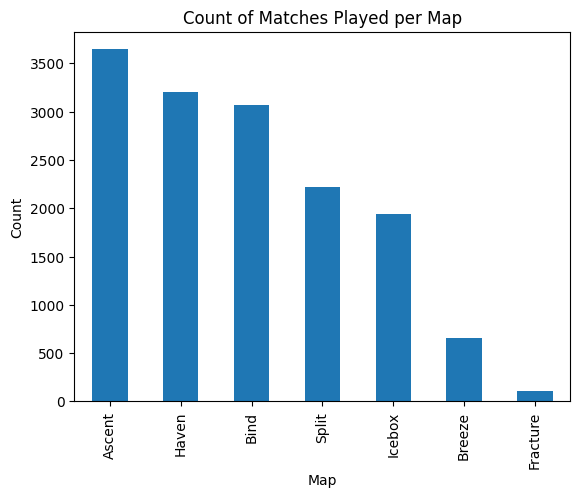

In [25]:
# Count the number of matches played on each map
map_counts = games_df['Map'].value_counts()

# Create a bar chart of the map counts
map_counts.plot.bar()

# Set the title and axis labels
plt.title('Count of Matches Played per Map')
plt.xlabel('Map')
plt.ylabel('Count')

# Show the plot
plt.show()

In [65]:
merged_df = pd.merge(matches_df[['MatchID', 'Date', 'Team1', 'Team2', 'Team1_MapScore','Team2_MapScore']], games_df[['MatchID', 'GameID', 'Map', 'Winner']], on='MatchID')
print(merged_df.columns)

Index(['MatchID', 'Date', 'Team1', 'Team2', 'Team1_MapScore', 'Team2_MapScore',
       'GameID', 'Map', 'Winner'],
      dtype='object')


In [66]:
merged_df = pd.merge(merged_df[['MatchID', 'Date', 'Team1', 'Team2', 'Team1_MapScore', 'Team2_MapScore', 'GameID', 'Map', 'Winner']], scoreboard_df_prep, on='GameID')

merged_df = merged_df.drop('MatchID', axis=1)

#print(merged_df)
merged_df.head()

,Date,Team1,Team2,Team1_MapScore,Team2_MapScore,GameID,Map,Winner,Agent,ACS,...,PlayerName_zeeq,PlayerName_zekken,PlayerName_zeldris,PlayerName_zhan,PlayerName_zill,PlayerName_zizox,PlayerName_zombs,PlayerName_zyad,PlayerName_zyf,PlayerName_Λero
0,2022-01-08 15:30:00,Booster Seat Gaming,Pho Real,2,1,60894,Breeze,Booster Seat Gaming,jett,313.0,...,0,0,0,0,0,0,0,0,0,0
1,2022-01-08 15:30:00,Booster Seat Gaming,Pho Real,2,1,60894,Breeze,Booster Seat Gaming,chamber,227.0,...,0,0,0,0,0,0,0,0,0,0
2,2022-01-08 15:30:00,Booster Seat Gaming,Pho Real,2,1,60894,Breeze,Booster Seat Gaming,sova,226.0,...,0,0,0,0,0,0,0,0,0,0
3,2022-01-08 15:30:00,Booster Seat Gaming,Pho Real,2,1,60894,Breeze,Booster Seat Gaming,viper,218.0,...,0,0,0,0,0,0,0,0,0,0
4,2022-01-08 15:30:00,Booster Seat Gaming,Pho Real,2,1,60894,Breeze,Booster Seat Gaming,skye,80.0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
merged_df.shape

(3127, 644)

In [30]:
data = merged_df.drop(['GameID', 'Date', 'Team1_MapScore', 'Team2_MapScore'], axis=1)

print(data.columns)

Index(['Team1', 'Team2', 'Map', 'Winner', 'Agent', 'ACS', 'Kills', 'Deaths',
       'Assists', 'KAST_Percent',
       ...
       'PlayerName_zeeq', 'PlayerName_zekken', 'PlayerName_zeldris',
       'PlayerName_zhan', 'PlayerName_zill', 'PlayerName_zizox',
       'PlayerName_zombs', 'PlayerName_zyad', 'PlayerName_zyf',
       'PlayerName_Λero'],
      dtype='object', length=640)


In [31]:
data = data.dropna()
print(data.shape)

(3127, 640)


In [32]:
# One-hot encode categorical features
data = pd.get_dummies(data, columns=['Map', 'Team1', 'Team2', 'Agent'])

In [33]:
scaler = MinMaxScaler()

numerical_cols = [ 'ACS', 'Kills', 'Deaths',
       'Assists', 'KAST_Percent', 'ADR', 'HS_Percent']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# pd.set_option('display.max_columns', None)
print(data.shape)
data.head()

(3127, 806)


,Winner,ACS,Kills,Deaths,Assists,KAST_Percent,ADR,HS_Percent,PlayerName_1TaPGoD,PlayerName_1van,...,Agent_kayo,Agent_killjoy,Agent_omen,Agent_phoenix,Agent_raze,Agent_reyna,Agent_sage,Agent_skye,Agent_sova,Agent_viper
0,Booster Seat Gaming,0.586724,0.611111,0.310345,0.136364,0.593023,0.630597,0.424658,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Booster Seat Gaming,0.402570,0.388889,0.310345,0.318182,0.883721,0.503731,0.219178,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Booster Seat Gaming,0.400428,0.416667,0.275862,0.363636,0.825581,0.455224,0.369863,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Booster Seat Gaming,0.383298,0.416667,0.379310,0.090909,0.651163,0.429104,0.260274,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Booster Seat Gaming,0.087794,0.083333,0.413793,0.136364,0.651163,0.108209,0.301370,0,0,...,0,0,0,0,0,0,0,1,0,0


<h2>Training the Model</h2>

In [43]:
X = data.drop(['Winner'], axis=1)
y = data['Winner']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators = 100)
model.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
#precision = precision_score(y_test, y_pred)
#recall = recall_score(y_test, y_pred)
print('accuracy score:', accuracy)
confusion_matrix(y_test, y_pred)
#print('Precision Score: ', precision_score(y_test, y_pred))
#print("Recall Score: ", recall)

accuracy score: 0.9297124600638977


array([[10,  0,  0, ...,  0,  0,  0],
       [ 0,  2,  0, ...,  0,  0,  0],
       [ 0,  0,  7, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  1,  0,  0],
       [ 0,  0,  0, ...,  0,  4,  0],
       [ 0,  0,  0, ...,  0,  0,  2]])

In [44]:
res_df = X_test
res_df['Predicted_Winner'] = y_pred
res_df['True_Winner'] = y_test

res_df['Correct_Prediction'] = (res_df['Predicted_Winner'] == res_df['True_Winner']).astype(int)
res_df[['Predicted_Winner', 'True_Winner', 'Correct_Prediction']].head(10)

,Predicted_Winner,True_Winner,Correct_Prediction
1188,SUPER SQUAD,SUPER SQUAD,1
1134,CoT,CoT,1
2159,Fire Flux Young,Fire Flux Young,1
1467,Zero MarksMen Black,Zero MarksMen Black,1
1072,Akrew,Akrew,1
1702,VIRTUOSO,VIRTUOSO,1
291,Team Valor,Team Valor,1
889,Akrew,Akrew,1
2469,Envy,Envy,1
1614,Built By Gamers Academy,Built By Gamers Academy,1


<Axes: xlabel='Predicted', ylabel='Correct_Prediction'>

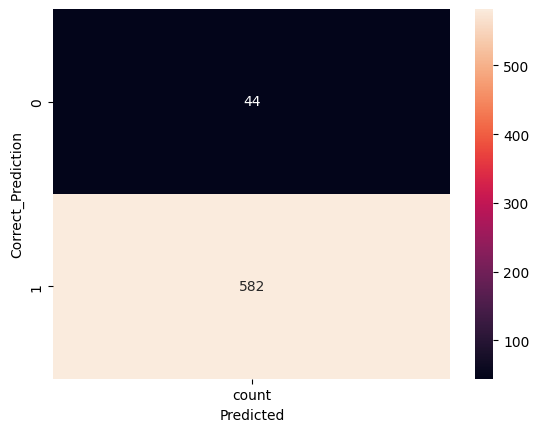

In [45]:
# Create contingency table
ctab = pd.crosstab(index=res_df['Correct_Prediction'], colnames=['Predicted'], columns='count')

# Plot heatmap
sns.heatmap(ctab, annot=True, fmt='d')

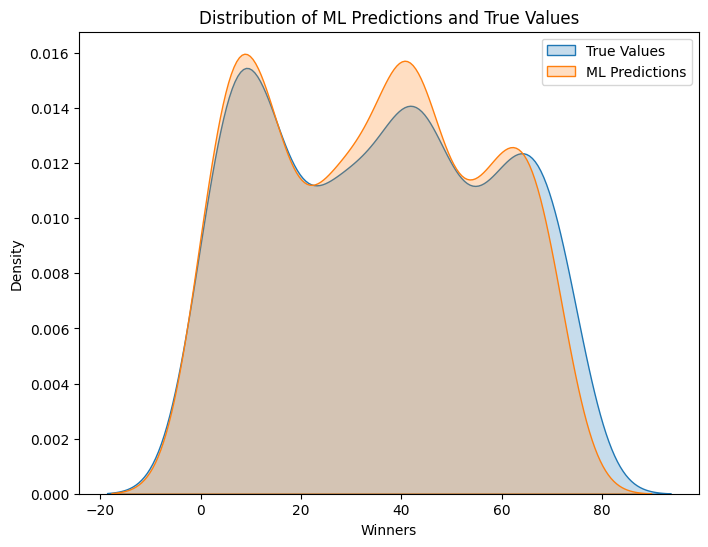

In [46]:
def plot_predictions(res_df):

    res_df['Predicted_Winner'] = res_df['Predicted_Winner'].astype('category')
    res_df['True_Winner'] = res_df['True_Winner'].astype('category')
    res_df['Predicted_Winner'] = res_df['Predicted_Winner'].cat.codes
    res_df['True_Winner'] = res_df['True_Winner'].cat.codes

    plt.figure(figsize=(8,6))
    sns.kdeplot(data=res_df, x=f'True_Winner', label='True Values', fill=True)
    sns.kdeplot(data=res_df, x=f'Predicted_Winner', label='ML Predictions', fill=True)
    plt.xlabel('Winners')
    plt.ylabel('Density')
    plt.title('Distribution of ML Predictions and True Values')
    plt.legend()
    plt.show()

plot_predictions(res_df)

# Prediction from Scoreboard

<h2>Pre-processing Data</h2>

In [47]:
player_data = scoreboard_df[['PlayerName', 'ACS', 'Agent', 'ADR',
                'Econ', 'TeamAbbreviation',
                'Kills', 'Deaths', 'Assists']]

player_data.head()

,PlayerName,ACS,Agent,ADR,Econ,TeamAbbreviation,Kills,Deaths,Assists
0,Reduxx,313.0,jett,195.0,74.0,Boos,24.0,10.0,3.0
1,ChurmZ,227.0,chamber,161.0,67.0,Boos,16.0,10.0,7.0
2,diaamond,226.0,sova,148.0,58.0,Boos,17.0,9.0,8.0
3,Boltzy,218.0,viper,141.0,48.0,Boos,17.0,12.0,2.0
4,Virtyy,80.0,skye,55.0,21.0,Boos,5.0,13.0,3.0


In [48]:
player_data.isnull().sum()

PlayerName           0
ACS                  0
Agent                0
ADR                  0
Econ                 0
TeamAbbreviation    43
Kills                0
Deaths               0
Assists              0
dtype: int64

In [49]:
player_data = player_data.dropna()

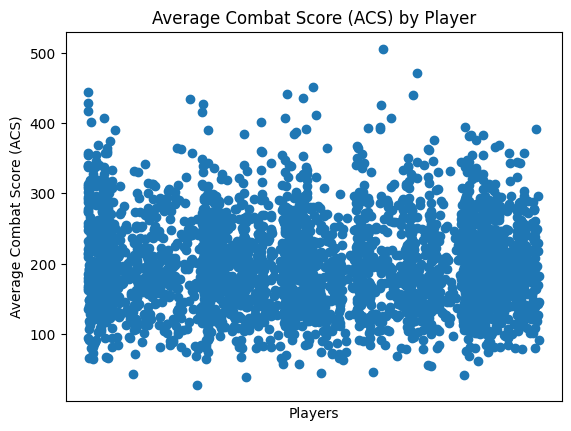

In [50]:
# Create a scatter plot of ACS vs. PlayerName
plt.scatter(player_data['PlayerName'], player_data['ACS'])

# Set the title and axis labels
plt.title('Average Combat Score (ACS) by Player')
plt.xlabel('Players')
plt.ylabel('Average Combat Score (ACS)')

# Remove x-axis labels
plt.xticks([], [])

# Increase the size of the plot
plt.rcParams['figure.figsize'] = [16, 9]

# Show the plot
plt.show()

In [51]:
# Preprocess the data
# one hot encode categorical features
player_data = pd.get_dummies(player_data, columns=['Agent', 'TeamAbbreviation'])

# Scale the numerical features using StandardScaler
scaler = MinMaxScaler()
numerical_cols = ['ACS', 'Econ', 'ADR', 'Kills', 'Deaths', 'Assists']
player_data[numerical_cols] = scaler.fit_transform(player_data[numerical_cols])

player_data.head()

,PlayerName,ACS,ADR,Econ,Kills,Deaths,Assists,Agent_astra,Agent_breach,Agent_brimstone,...,TeamAbbreviation_XSET,TeamAbbreviation_YFP,TeamAbbreviation_ZMM.B,TeamAbbreviation_Zeni,TeamAbbreviation_cism,TeamAbbreviation_ex-FB,TeamAbbreviation_ex-L,TeamAbbreviation_ex-S,TeamAbbreviation_same,TeamAbbreviation_waff
0,Reduxx,0.596234,0.637363,0.356383,0.621622,0.310345,0.136364,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ChurmZ,0.416318,0.512821,0.319149,0.405405,0.310345,0.318182,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,diaamond,0.414226,0.465201,0.271277,0.432432,0.275862,0.363636,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Boltzy,0.397490,0.439560,0.218085,0.432432,0.379310,0.090909,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Virtyy,0.108787,0.124542,0.074468,0.108108,0.413793,0.136364,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2>Training the Model</h2>

In [59]:
X = player_data.drop(['PlayerName'], axis=1)
y = player_data['PlayerName']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#print(X_train)
print(X_test)

           ACS       ADR      Econ     Kills    Deaths   Assists  Agent_astra  \
2994  0.437238  0.472527  0.260638  0.486486  0.586207  0.045455            0   
440   0.851464  0.937729  0.845745  0.567568  0.206897  0.181818            0   
960   0.476987  0.501832  0.271277  0.432432  0.551724  0.136364            0   
1235  0.301255  0.351648  0.228723  0.432432  0.413793  0.318182            0   
53    0.355649  0.424908  0.250000  0.351351  0.517241  0.181818            0   
...        ...       ...       ...       ...       ...       ...          ...   
592   0.361925  0.435897  0.265957  0.459459  0.655172  0.272727            0   
820   0.682008  0.857143  0.441489  0.486486  0.344828  0.363636            0   
799   0.123431  0.183150  0.095745  0.054054  0.482759  0.090909            0   
2603  0.305439  0.369963  0.202128  0.270270  0.379310  0.136364            0   
58    0.225941  0.289377  0.196809  0.297297  0.379310  0.181818            0   

      Agent_breach  Agent_b

In [53]:
model = RandomForestClassifier(n_estimators = 150)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)


print("The Training accuracy of the model is {:.2f}".format(model.score(X_train, y_train)))
print("The Testing accuracy of the model is {:.2f}".format(model.score(X_test, y_test)))

res_df = X_test
res_df['Predicted_PlayerName'] = test_pred
res_df['True_PlayerName'] = y_test
res_df = res_df.sort_values(by='ACS', axis=0, ascending=False)
res_df[['Predicted_PlayerName', 'True_PlayerName']].head(10)

The Training accuracy of the model is 1.00
The Testing accuracy of the model is 0.62


,Predicted_PlayerName,True_PlayerName
2299,SkRossi,SkRossi
1412,supA,tech
440,Nhatthong2k,Redneval
1542,gucc107,C0M
180,Reduxx,Virtyy
260,stellar,bang
1642,runi,runi
3121,leaf,leaf
200,FIEND,FIEND
1652,Reduxx,Reduxx


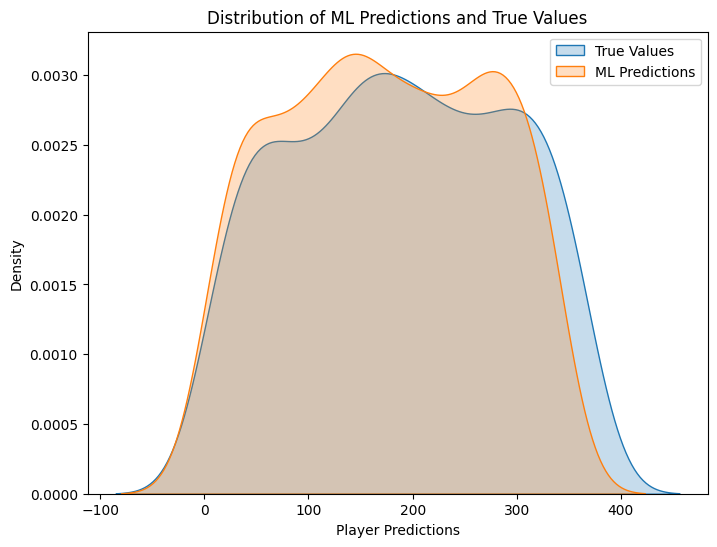

In [54]:
def plot_predictions(res_df):

    res_df['Predicted_PlayerName'] = res_df['Predicted_PlayerName'].astype('category')
    res_df['True_PlayerName'] = res_df['True_PlayerName'].astype('category')
    res_df['Predicted_PlayerName'] = res_df['Predicted_PlayerName'].cat.codes
    res_df['True_PlayerName'] = res_df['True_PlayerName'].cat.codes

    plt.figure(figsize=(8,6))
    sns.kdeplot(data=res_df, x=f'True_PlayerName', label='True Values', fill=True)
    sns.kdeplot(data=res_df, x=f'Predicted_PlayerName', label='ML Predictions', fill=True)
    plt.xlabel('Player Predictions')
    plt.ylabel('Density')
    plt.title('Distribution of ML Predictions and True Values')
    plt.legend()
    plt.show()

plot_predictions(res_df)

# Match Prediction from Team Stats

<h2>Pre-processing Data</h2>

In [8]:
%%capture
def team_df(df, stat, players):

    df_list = []
    for name in players:
        mask = (df['PlayerName'] == name)
        roster = df[mask]
        roster = roster[['PlayerName', stat]]                           # take corresponding player stats
        roster.rename(columns={stat: f'{name}_{stat}'}, inplace=True)   # rename stats after player name
        df_list.append(roster)

    team = pd.DataFrame()

    for i in range(len(df_list)):

        if i == 0:
            team = df_list[i]

        else:
            team = team.merge(df_list[i], how='outer')

    team = team.fillna(0)
    team = pd.get_dummies(team)
    team[stat] = 0

    for name in players:
        team[stat] += team[f'{name}_{stat}']

    return team

In [56]:
team = team_df(merge_df, stat='ACS',
                 players=['bdog', 's0m', "TenZ", 'Reduxx', 'ChurmZ'])
team.head()

,bdog_ACS,s0m_ACS,TenZ_ACS,Reduxx_ACS,ChurmZ_ACS,PlayerName_ChurmZ,PlayerName_Reduxx,PlayerName_TenZ,PlayerName_bdog,ACS
0,251.0,0.0,0.0,0.0,0.0,0,0,0,1,251.0
1,246.0,0.0,0.0,0.0,0.0,0,0,0,1,246.0
2,218.0,0.0,0.0,0.0,0.0,0,0,0,1,218.0
3,225.0,0.0,0.0,0.0,0.0,0,0,0,1,225.0
4,198.0,0.0,0.0,0.0,0.0,0,0,0,1,198.0


In [10]:
team.shape

(71, 10)

<h2>Training the Model</h2>

In [11]:
def team_stat_predict(df, stat, players):

    team = team_df(df, stat, players)

    # scaler = StandardScaler()
    # numerical_cols = ['bdog_ACS', 's0m_ACS', 'TenZ_ACS', 'Reduxx_ACS', 'ChurmZ_ACS']
    # team[numerical_cols] = scaler.fit_transform(team[numerical_cols])

    model = DecisionTreeRegressor()
    # model = RandomForestClassifier(n_estimators=100)


    X = team.drop([f'{stat}'], axis=1)
    y = team[f'{stat}']

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    test_pred = model.predict(X_test)

    accuracy = model.score(X_test, y_test)

    # print("The Training accuracy of the model is {:.2f}".format(model.score(X_train, y_train)))
    # print("The Testing accuracy of the model is {:.2f}".format(model.score(X_test, y_test)))

    res_df = X_test
    res_df[f'ML_{stat}'] = test_pred
    res_df[f'True_{stat}'] = y_test
    RMS = mean_squared_error(y_test, test_pred)
    RAE= mean_absolute_error(y_test, test_pred)
    R2 = r2_score(y_test, test_pred)
    average = np.average(test_pred)


    return average, accuracy, res_df, RMS, RAE, R2

In [14]:
# players = ['Reduxx', 'TenZ', 'MaKo', 'Shao', 'Bdog']
players = ['supA', 's0m', "leaf", 'runi', 'ChurmZ']
stats = 'ACS'

average, accuracy, res, RMS_e, RAE_e, R2_e = team_stat_predict(merge_df, stats, players)

print('Accuracy: ', accuracy)
print('Average stats: ', average)
print('MSE: ', RMS_e)
print('MAE: ', RAE_e)
print('R2: ', R2_e)

res.head()

Accuracy:  0.8956091647472421
Average stats:  202.0
MSE:  1063.111111111111
MAE:  20.88888888888889
R2:  0.8956091647472421


,supA_ACS,s0m_ACS,leaf_ACS,runi_ACS,ChurmZ_ACS,PlayerName_ChurmZ,PlayerName_leaf,PlayerName_runi,PlayerName_supA,ML_ACS,True_ACS
39,0.0,0.0,0.0,0.0,107.0,1,0,0,0,119.0,107.0
25,0.0,0.0,0.0,388.0,0.0,0,0,1,0,302.0,388.0
26,0.0,0.0,0.0,249.0,0.0,0,0,1,0,245.0,249.0
43,0.0,0.0,0.0,0.0,66.0,1,0,0,0,92.0,66.0
35,0.0,0.0,0.0,0.0,176.0,1,0,0,0,184.0,176.0


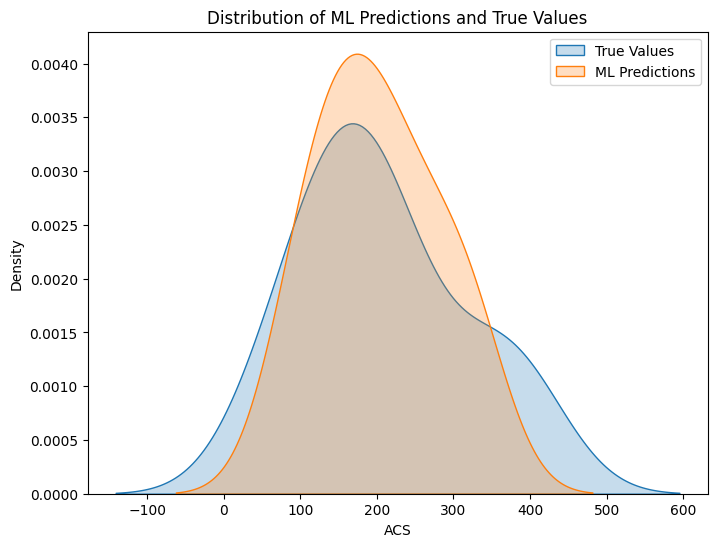

In [15]:
# %%capture
def plot_predictions(res_df, stat):
    plt.figure(figsize=(8,6))
    sns.kdeplot(data=res_df, x=f'True_{stat}', label='True Values', fill=True)
    sns.kdeplot(data=res_df, x=f'ML_{stat}', label='ML Predictions', fill=True)
    plt.xlabel(stat)
    plt.ylabel('Density')
    plt.title('Distribution of ML Predictions and True Values')
    plt.legend()
    plt.show()

plot_predictions(res, stats)

In [18]:
def match_predict(df, teamA, teamB, stats):

    teamA_score = 0.0
    teamB_score = 0.0

    # map_series = df[df['Map'] != 'TBD']
    map_list = df['Map'].unique().tolist()
    map_list.remove('Fracture')

    map = random.choice(map_list)

    print('MAP: ', map)

    for stat in stats:
        tA_stat_avg, accuracy_A, res_df, RMS_F, RAE_F, R2_F = team_stat_predict(df[df['Map'] == map],
                                            stat, teamA)
        tB_stat_avg, accuracy_B, res_df, RMS_F, RAE_F, R2_F = team_stat_predict(df[df['Map'] == map],
                                            stat, teamB)

        if tA_stat_avg > tB_stat_avg:
            teamA_score += 1
        elif tA_stat_avg < tB_stat_avg:
            teamB_score += 1
        else:
            teamA_score += .5
            teamB_score += .5


    if teamA_score > teamB_score:
        print(f'Team A won in {map}')
        print(RMS_F)

    elif teamA_score < teamB_score:
        print(f'Team B won in {map}')

    else:
        coinflip = np.random.randint(2)
        if coinflip == 0:
            print(f'Team A won in {map} (OT)')

        else:
            print(f'Team B won in {map} (OT)')


In [ ]:
# checking name
name = "yay"

# boolean variable
found = False

# iterate over each row
for index, row in merge_df.iterrows():

    # check if name is present in row
    if row["PlayerName"] == name:

        # if present, set found to True and break loop
        found = True

        break;


if found:

    print("Name found in csv file")


else:

    print("Name not found in csv file")

Name found in csv file


In [20]:
import warnings
warnings.filterwarnings('ignore')

team1 = ['supA', 'TenZ', 'MaKo', 'Shao', 'Bdog']
team2 = ['Reduxx', 's0m', "leaf", 'runi', 'ChurmZ']
match_predict(merge_df, team1, team2, ['ACS', 'Econ', 'Kills', 'ADR', 'Assists', 'KAST_Percent'])

MAP:  Split
Team B won in Split
